In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
idx = pd.IndexSlice
pd.set_option("display.max_rows",101)
pd.set_option('expand_frame_repr', False)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# MRChem benchmark calculations

This notebook presents benchmark timings for the MRChem program on a set of molecular calculations using a variable number of CPU cores. The test systems are standard linear alkane chains $C_nH_{2n+2}$, with $n$ ranging from 2 to 350, as well as the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) and Valinomycine ($C_{54}H_{90}N_{6}O_{18}$) molecules. The main purpose of this data is to monitor the development of the code performance between different version, but it will also provide a reference for users to check if the code has been properly installed and runs reasonably on their system. Not all molecular systems will be available in the data, which mirrors the current limitations of the code when it comes to system size and numerical precision. Only a small selection of the data will be presented below, but further details are available by digging into the raw data.

## MRChem SCF cycle

The Self-Consistent Field (SCF) cycle in MRChem contains the following steps:

- Building Fock operator
- Calculating Fock matrix
- Rotating orbitals (diagonalization or localization)
- Calculating SCF energy
- Applying Helmholtz operator
- Applying iterative subspace acceleration (KAIN)

and each of these may have sub steps that can be extracted from the data below. The calculations are performed using one of the following methods:

- Hartree (to show the performance of the backbone SCF algorithm + Coulomb interaction)
- Hartree-Fock (to show the performance of the exact exchange operator)
- DFT-PBE (to show the performance of the density functional integrator)

## Parallel performance

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes and OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

In [2]:
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine-pbe/scf.csv", index_col=[0,1,2])
hybrid_frame.loc[mol,:,:]

Localize  SCF energy  Helmholtz   Lowdin      KAIN  Fock operator  Fock matrix  Total SCF
MPI OMP                                                                                           
1   1    415.4980   423.26800  4953.4300  70.9645  43.59800      309.06400     525.3980   6786.840
    2    259.7540   229.15100  2566.9000  46.0141  26.04800      160.38000     316.7990   3634.920
    5    163.1780   114.47300  1167.3200  33.4915  15.62510       71.27340     183.8990   1771.150
    10   134.7700    75.31530   679.1150  29.3447  12.32330       40.07930     142.9190   1133.180
    20   122.4560    59.39030   497.4930  28.8793  11.19000       28.07660     121.8280    888.121
    40   132.2590    59.70600   341.2460  29.6806  13.63990       18.14540     125.7700    739.873
2   1    242.8330   222.08900  2571.2900  53.1483  23.38170      228.61100     292.0990   3665.740
    2    159.8440   124.33800  1390.1200  36.3454  15.13380      121.92500     182.1300   2052.080
    5    110.8530    63.42350   636.0230  27.7124   8.93415       55.11120     115.1410   1035.430
    10    95.3291    44.28140   421.0250  25.1772   7.08878       35.58320      93.3740    739.045
    20    84.4119    30.24350   253.0550  24.4906   5.84756       19.86850      75.8652    510.096
    40    90.9860    28.22500   177.0570  23.4733   6.48530       13.83260      77.4998    435.310
4   1    134.6100   112.91700  1262.0900  84.8726  13.03520      180.42300     152.4100   1961.780
    2     91.3148    62.18000   689.1570  54.1657   7.80896       97.29150      96.7915   1115.010
    5     65.4617    30.69960   314.5190  27.1226   4.75908       43.60220      60.7325    560.585
    10    58.6881    21.73690   212.4990  20.4882   3.79225       28.38830      50.7467    409.777
    20    53.3177    14.77660   123.2010  24.6529   3.26285       15.55130      42.5874    290.247
    40    54.5864    14.65260    89.3609  17.1709   3.46371       10.21660      41.9868    245.068
6   1    102.4890    81.13040   927.7510  71.0974  10.49720      172.94500     112.9290   1496.230
    2     71.2814    46.32240   522.8840  37.4677   6.05828       95.00630      71.0304    864.039
    5     54.0697    24.36690   258.3860  23.4380   3.90072       45.67430      47.0351    468.616
    10    43.7746    14.67410   148.1950  14.0063   2.70080       25.53620      35.4027    295.161
    20    39.7609     9.72782    87.1343  15.9377   2.35251       14.26650      30.3130    209.857
    40    40.0226    10.00250    60.7483  15.9153   2.84738        9.80183      30.3040    180.408
8   1     79.3227    61.72820   717.4050  42.7307   7.18189      164.68500      85.4514   1176.650
    2     53.8401    33.45960   380.0310  27.4737   4.24980       86.04990      53.9022    653.278
    5     41.6008    19.98650   211.4250  20.7110   2.71665       46.40910      38.0481    393.262
    10    34.3786    12.13870   117.6790  15.9146   2.18020       26.32750      29.4669    248.406
    20    30.5493     7.92669    67.7736  13.8615   1.73922       13.98470      24.3259    169.964
10  1     72.4217    52.71390   620.7320  26.4349   6.03097      163.44800      74.1071   1034.380
    2     50.2822    29.43520   335.1740  19.1877   3.68428       88.11080      48.0603    588.215
    5     36.6455    14.86690   165.2870  20.3774   2.24243       43.61530      32.9662    327.839
    10    30.1311     9.14570    91.4468  14.2671   1.52355       23.60350      26.2371    206.709
    20    27.0648     6.04240    57.3783  11.3393   1.28976       13.48360      21.6919    148.803
12  1     61.6032    41.60590   470.1010  61.9820   5.24189      151.65100      62.5420    873.272
    2     43.3094    22.72310   250.3580  37.8535   3.09756       79.66140      41.7537    492.983
    5     33.5974    13.03030   134.5200  25.4764   2.05239       41.61350      31.5828    294.188
    10    28.2121     7.95684    73.4786  21.6763   1.53525       21.67610      25.0804    191.431
    20    23.9380     5.39246    45.5242  14.5591

## OpenMP scaling

The following table presents timings (in sec) on a single compute node for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

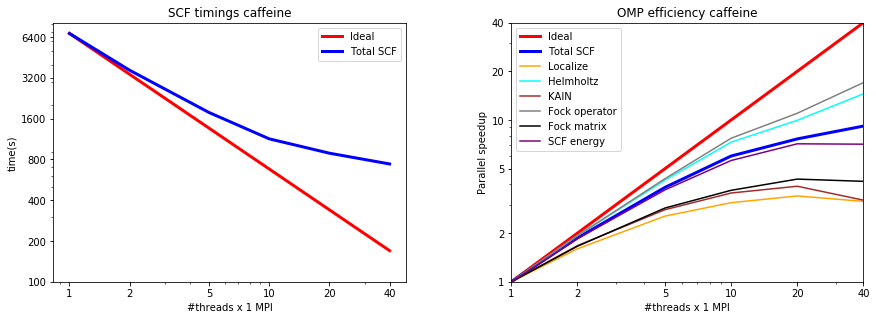

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
OMP,,,,,,,,
1,415.498,423.2680,4953.430,70.9645,43.5980,309.0640,525.398,6786.840
2,259.754,229.1510,2566.900,46.0141,26.0480,160.3800,316.799,3634.920
5,163.178,114.4730,1167.320,33.4915,15.6251,71.2734,183.899,1771.150
10,134.770,75.3153,679.115,29.3447,12.3233,40.0793,142.919,1133.180
20,122.456,59.3903,497.493,28.8793,11.1900,28.0766,121.828,888.121
40,132.259,59.7060,341.246,29.6806,13.6399,18.1454,125.770,739.873


In [3]:
mpi=1
mol='caffeine'
omp_frame = pd.read_csv("caffeine-pbe/scf.csv", index_col=[0,1,2])
omp_series = omp_frame.loc[mol,mpi]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(omp_series.index, mpi*omp_series['Total SCF'][mpi]/omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(omp_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([100, 200, 400, 800, 1600, 3200, 6400], [100, 200, 400, 800, 1600, 3200, 6400])
plt.xticks([1, 2, 5, 10, 20, 40], [1, 2, 5, 10, 20, 40])
plt.ylabel('time(s)')
plt.xlabel('#threads' + ' x ' + str(mpi) + ' MPI')

plt.subplot(122)
plt.title('OMP efficiency ' + mol)
plt.plot(omp_series.index, omp_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi*omp_series['Total SCF'][mpi]/omp_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(mpi*omp_series['Localize'][mpi]/omp_series['Localize'], c='orange', label='Localize')
plt.plot(mpi*omp_series['Helmholtz'][mpi]/omp_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(mpi*omp_series['KAIN'][mpi]/omp_series['KAIN'], c='brown', label='KAIN')
plt.plot(mpi*omp_series['Fock operator'][mpi]/omp_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(mpi*omp_series['Fock matrix'][mpi]/omp_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(mpi*omp_series['SCF energy'][mpi]/omp_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.axis([8, 32, 8, 32])
plt.yscale('log')
plt.xscale('log')
plt.yticks([1, 2, 5, 10, 20, 40], [1, 2, 5, 10, 20, 40])
plt.xticks([1, 2, 5, 10, 20, 40], [1, 2, 5, 10, 20, 40])
plt.ylabel('Parallel speedup')
plt.xlabel('#threads' + ' x ' + str(mpi) + ' MPI')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
omp_frame.loc[mol,mpi,:]

## MPI scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes with fixed a single OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

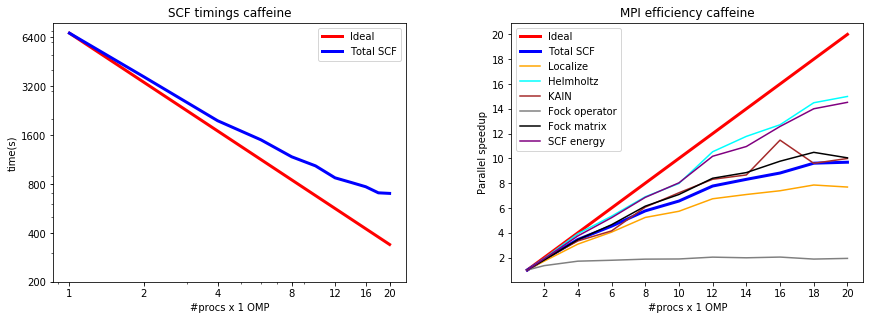

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,415.4980,423.2680,4953.430,70.9645,43.59800,309.064,525.3980,6786.840
2,242.8330,222.0890,2571.290,53.1483,23.38170,228.611,292.0990,3665.740
4,134.6100,112.9170,1262.090,84.8726,13.03520,180.423,152.4100,1961.780
6,102.4890,81.1304,927.751,71.0974,10.49720,172.945,112.9290,1496.230
8,79.3227,61.7282,717.405,42.7307,7.18189,164.685,85.4514,1176.650
10,72.4217,52.7139,620.732,26.4349,6.03097,163.448,74.1071,1034.380
12,61.6032,41.6059,470.101,61.9820,5.24189,151.651,62.5420,873.272
14,58.6121,38.6225,420.646,61.1554,5.03134,155.659,59.3310,816.538
16,56.2150,33.6571,389.646,62.3493,3.80012,151.232,53.7553,769.390


In [4]:
omp=1
ref=1
mol='caffeine'
mpi_frame = pd.read_csv("caffeine-pbe/scf.csv", index_col=[0,2,1])
mpi_series = mpi_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(mpi_series.index, ref*mpi_series['Total SCF'][ref]/mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(mpi_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([200, 400, 800, 1600, 3200, 6400], [200, 400, 800, 1600, 3200, 6400])
plt.xticks([1, 2, 4, 8, 12, 16, 20], [1, 2, 4, 8, 12, 16, 20])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' x ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('MPI efficiency ' + mol)
plt.plot(mpi_series.index, mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*mpi_series['Total SCF'][ref]/mpi_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(ref*mpi_series['Localize'][ref]/mpi_series['Localize'], c='orange', label='Localize')
plt.plot(ref*mpi_series['Helmholtz'][ref]/mpi_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(ref*mpi_series['KAIN'][ref]/mpi_series['KAIN'], c='brown', label='KAIN')
plt.plot(ref*mpi_series['Fock operator'][ref]/mpi_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(ref*mpi_series['Fock matrix'][ref]/mpi_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(ref*mpi_series['SCF energy'][ref]/mpi_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
#plt.yscale('log')
#plt.xscale('log')
plt.yticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], [2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], [2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' x ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp]

## Hybrid MPI/OpenMP scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) molecule at numerical precision $\epsilon=10^{-5}$, using the PBE density functional. The calculations are using an increasing number of MPI processes with fixed 20 OMP threads per process. The molecule has 102 electrons and 51 doubly occupied molecular orbitals.

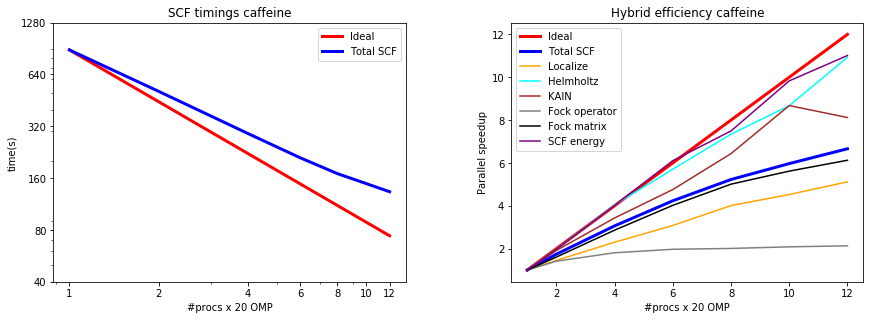

,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
MPI,,,,,,,,
1,122.4560,59.39030,497.4930,28.8793,11.19000,28.0766,121.8280,888.121
2,84.4119,30.24350,253.0550,24.4906,5.84756,19.8685,75.8652,510.096
4,53.3177,14.77660,123.2010,24.6529,3.26285,15.5513,42.5874,290.247
6,39.7609,9.72782,87.1343,15.9377,2.35251,14.2665,30.3130,209.857
8,30.5493,7.92669,67.7736,13.8615,1.73922,13.9847,24.3259,169.964
10,27.0648,6.04240,57.3783,11.3393,1.28976,13.4836,21.6919,148.803
12,23.9380,5.39246,45.5242,14.5591,1.37814,13.1879,19.8936,133.345


In [5]:
omp=20
ref=1
mol='caffeine'
hybrid_frame = pd.read_csv("caffeine-pbe/scf.csv", index_col=[0,2,1])
hybrid_series = hybrid_frame.loc[mol,omp]

plt.subplot(121)
plt.title('SCF timings ' + mol)
plt.plot(hybrid_series.index, ref*hybrid_series['Total SCF'][ref]/hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(hybrid_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([40, 80, 160, 320, 640, 1280], [40, 80, 160, 320, 640, 1280])
plt.xticks([1, 2, 4, 6, 8, 10, 12], [1, 2, 4, 6, 8, 10, 12])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' x ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('Hybrid efficiency ' + mol)
plt.plot(hybrid_series.index, hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*hybrid_series['Total SCF'][ref]/hybrid_series['Total SCF'], c='blue', lw=3, label='Total SCF')
plt.plot(ref*hybrid_series['Localize'][ref]/hybrid_series['Localize'], c='orange', label='Localize')
plt.plot(ref*hybrid_series['Helmholtz'][ref]/hybrid_series['Helmholtz'], c='cyan', label='Helmholtz')
plt.plot(ref*hybrid_series['KAIN'][ref]/hybrid_series['KAIN'], c='brown', label='KAIN')
plt.plot(ref*hybrid_series['Fock operator'][ref]/hybrid_series['Fock operator'], c='gray', label='Fock operator')
plt.plot(ref*hybrid_series['Fock matrix'][ref]/hybrid_series['Fock matrix'], c='black', label='Fock matrix')
plt.plot(ref*hybrid_series['SCF energy'][ref]/hybrid_series['SCF energy'], c='purple', label='SCF energy')
plt.legend(loc='upper left')
plt.yticks([2, 4, 6, 8, 10, 12], [2, 4, 6, 8, 10, 12])
plt.xticks([2, 4, 6, 8, 10, 12], [2, 4, 6, 8, 10, 12])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' x ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[mol,omp,:]